# Import Library and Load Data

Link dataset: https://www.kaggle.com/datasets/mdatikurrahman3111/vegetables-quality-dataset-2

In [ ]:
!pip install opencv-contrib-python

import numpy as np, matplotlib.pyplot as plt, seaborn as sns, cv2, cv2.ximgproc, os, math, pandas as pd
from pathlib import Path
from collections import Counter
from scipy.ndimage import label as scipy_label

# Machine Learning & Metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Feature Extractors
from skimage.feature import local_binary_pattern, hog

import warnings
warnings.filterwarnings('ignore')

# Konfigurasi Plotting
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries berhasil diimpor")

Libraries berhasil diimpor


Mounted at /content/drive
Dataset Path diatur ke: /content/drive/MyDrive/PCVK/dataset_cm2/New Data
Membaca direktori...
  -> Loading Bad Quality Carrot: 691 images
  -> Loading Bad Quality Potato: 260 images
  -> Loading Bad Quality Tomato: 288 images
  -> Loading Good Quality Carrot: 347 images
  -> Loading Good Quality Potato: 217 images
  -> Loading Good Quality Tomato: 424 images

Total Gambar Dimuat: 2227

Jumlah data per kualitas:
- Rusak: 1239 gambar
- Utuh: 988 gambar


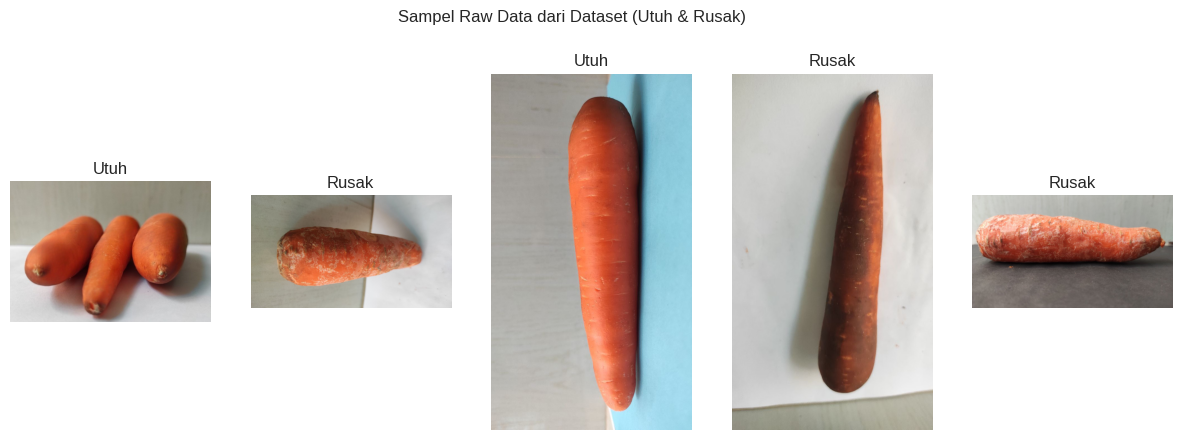

In [ ]:
# ==========================================
# STEP 1: LOAD DATA & VISUALISASI RAW DATA
# ==========================================

from google.colab import drive
drive.mount('/content/drive')

# Format folder harus: "Bad Quality Potato", "Good Quality Carrot", dsb.
dataset_path = Path(r"/content/drive/MyDrive/PCVK/dataset_cm2/New Data")

print(f"Dataset Path diatur ke: {dataset_path}")

def parse_folder_info(folder_name):
    # Mengekstrak label utuh dan rusak
    name_lower = folder_name.lower()

    # Deteksi Kualitas
    quality = "Utuh" if "good" in name_lower else ("Rusak" if "bad" in name_lower else None)

    return quality

raw_images = [] # This will now store file paths
labels_quality = []

if dataset_path.exists():
    print("Membaca direktori...")
    for folder in sorted(dataset_path.iterdir()):
        if folder.is_dir():
            # Now parse_folder_info only returns 'qual'
            qual = parse_folder_info(folder.name)
            # We no longer need 'vtype' in this step for labels_type
            if qual:
                # Ambil semua ekstensi gambar
                files = list(folder.glob("*.jpg")) + list(folder.glob("*.png")) + list(folder.glob("*.jpeg"))
                print(f"  -> Loading {folder.name}: {len(files)} images")

                for f in files:
                    # Store file path instead of the image data to save RAM
                    raw_images.append(f)
                    labels_quality.append(qual)
else:
    print("Error: Path tidak ditemukan!")

print(f"\nTotal Gambar Dimuat: {len(raw_images)}")

# Menghitung jumlah 'Utuh' dan 'Rusak'
label_counts = Counter(labels_quality)
print("\nJumlah data per kualitas:")
for label, count in label_counts.items():
    print(f"- {label}: {count} gambar")

# ==================================================
#              VISUALISASI SAMPEL
# ==================================================
if len(raw_images) > 0:
    # Pisahkan indeks untuk 'Utuh' dan 'Rusak'
    utuh_indices = [i for i, label in enumerate(labels_quality) if label == 'Utuh']
    rusak_indices = [i for i, label in enumerate(labels_quality) if label == 'Rusak']

    selected_indices = []
    # Ambil 2 sampel 'Utuh'
    if len(utuh_indices) >= 2:
        selected_indices.extend(np.random.choice(utuh_indices, 2, replace=False))
    elif len(utuh_indices) > 0:
        selected_indices.extend(utuh_indices)

    # Ambil 3 sampel 'Rusak' atau sisanya jika 'Utuh' tidak cukup
    num_rusak_to_take = 5 - len(selected_indices)
    if len(rusak_indices) >= num_rusak_to_take:
        selected_indices.extend(np.random.choice(rusak_indices, num_rusak_to_take, replace=False))
    elif len(rusak_indices) > 0:
        selected_indices.extend(rusak_indices)

    # Shuffle the selected indices to mix 'Utuh' and 'Rusak'
    np.random.shuffle(selected_indices)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        if i >= 5: # Limit to 5 plots even if more were selected due to small categories
            break
        plt.subplot(1, 5, i+1)
        # Load image on demand for visualization
        img_to_show = cv2.imread(str(raw_images[idx]))
        if img_to_show is not None:
            img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
            plt.imshow(img_to_show)
        else:
            # Handle case where image could not be loaded
            plt.text(0.5, 0.5, "Image Error", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(labels_quality[idx]) # Menambahkan label kualitas pada judul
        plt.axis('off')
    plt.suptitle("Sampel Raw Data dari Dataset (Utuh & Rusak)")
    plt.show()


# Preprocessing

Memulai Preprocessing...
Total preprocessed image = 2227

====== HASIL PSNR ======
Rata-rata : 38.33 dB
Minimum   : 27.69 dB
Maksimum  : 46.27 dB



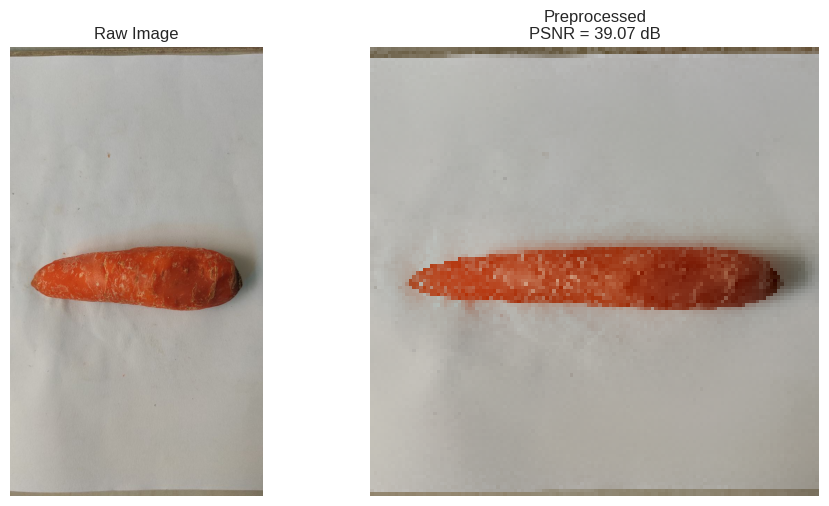

In [ ]:
# ===================================================
# STEP 2: PREPROCESSING (Resize + Guided Filter)
# ===================================================

def calculate_psnr(original, processed):
    mse = np.mean((original.astype("float") - processed.astype("float")) ** 2)
    if mse == 0:
        return 100
    return 20 * math.log10(255.0 / math.sqrt(mse))


def resize_image(img, size=128):
    return cv2.resize(img, (size, size))


def guided_filter_smoothing(img_rgb, radius, eps):
    img_float = img_rgb.astype(np.float32) / 255.0
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

    channels = []
    for c in range(3):
        ch = img_float[:, :, c]
        ch_filt = cv2.ximgproc.guidedFilter(guide=gray, src=ch, radius=radius, eps=eps)
        channels.append(ch_filt)

    smoothed = np.stack(channels, axis=2)
    return np.clip(smoothed * 255.0, 0, 255).astype(np.uint8)


# ======================================================================
#                   PREPROCESSING (NO AUGMENTATION)
# ======================================================================

preprocessed_images = []
psnr_after = []

print("Memulai Preprocessing...")

for img_path in raw_images:

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"[SKIP] Error loading: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    orig_r = resize_image(img, 128)

    # Guided filter
    den_r = guided_filter_smoothing(orig_r, radius=5, eps=1e-4)

    # Simpan 1x saja
    preprocessed_images.append(den_r)

    # PSNR
    psnr_after.append(calculate_psnr(orig_r, den_r))


print(f"Total preprocessed image = {len(preprocessed_images)}")

print("\n====== HASIL PSNR ======")
print(f"Rata-rata : {np.mean(psnr_after):.2f} dB")
print(f"Minimum   : {np.min(psnr_after):.2f} dB")
print(f"Maksimum  : {np.max(psnr_after):.2f} dB")
print("========================\n")

# ==========================================
# VISUALISASI PREPROCESSING
# ==========================================

idx = np.random.randint(0, len(preprocessed_images))

raw_img = cv2.imread(str(raw_images[idx]))
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

prep_img = preprocessed_images[idx]
psnr_val = calculate_psnr(resize_image(raw_img, 128), prep_img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(raw_img)
plt.title("Raw Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(prep_img)
plt.title(f"Preprocessed\nPSNR = {psnr_val:.2f} dB")
plt.axis("off")

plt.tight_layout()
plt.show()


# Segmentation and Augmentation

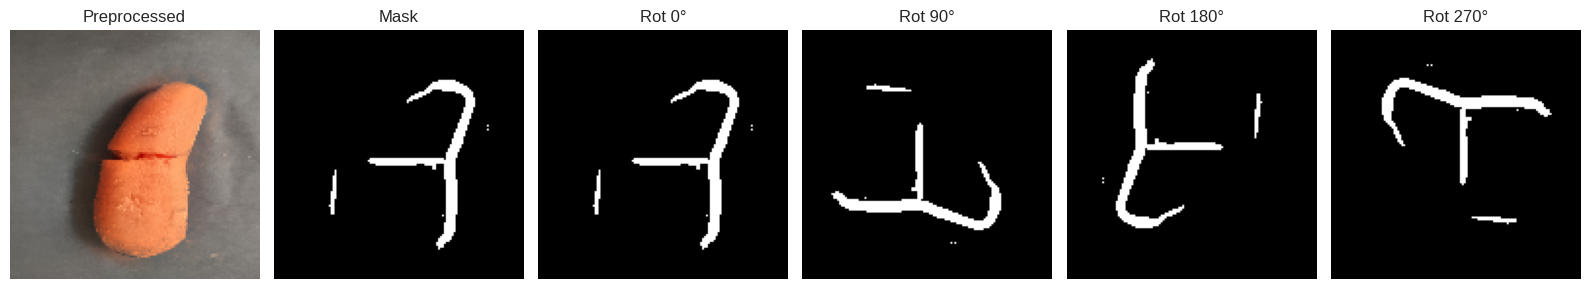

Jumlah citra asli              : 2227
Augmentasi per citra           : 4
Total citra setelah augmentasi : 8908


In [ ]:
# ===================================================
# STEP 3: IMAGE SEGMENTATION + MASK AUGMENTASI
# ===================================================

def segmentation(preprocessed_img):
    # Kernel based on article
    Kh = np.array([
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2]
    ], np.float32)

    Kv = np.array([
        [-2,-2,-2,-2,-2,-2,-2],
        [-1,-1,-1,-1,-1,-1,-1],
        [-1,-1,-1,-1,-1,-1,-1],
        [ 1, 1, 1, 1, 1, 1, 1],
        [ 1, 1, 1, 1, 1, 1, 1],
        [ 1, 1, 1, 1, 1, 1, 1],
        [ 2, 2, 2, 2, 2, 2, 2],
    ], np.float32)

    # 1. Convert to grayscale
    gray = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2GRAY).astype(np.float32)

    # 2. Convolution
    Gh = cv2.filter2D(gray, -1, Kh)
    Gv = cv2.filter2D(gray, -1, Kv)

    # 3. Select max gradient magnitude
    Gmag = np.maximum(np.abs(Gh), np.abs(Gv))
    Gmag_norm = cv2.normalize(Gmag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 4. Threshold
    _, mask = cv2.threshold(Gmag_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

# -------- MASK AUGMENTASI (0°, 90°, 180°, 270°) --------
def augment_mask(mask):
    mask = mask.astype(np.uint8)
    return [
        mask,  # 0°
        cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE),           # 90°
        cv2.rotate(mask, cv2.ROTATE_180),                    # 180°
        cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)     # 270°
    ]

# Buat aug_masks untuk semua citra
all_aug_masks = []
for img in preprocessed_images:
    mask = segmentation(img)          # mask hasil segmentasi citra
    masks = augment_mask(mask)        # list 4 rotasi
    all_aug_masks.append(masks)       # all_aug_masks[i][j] = mask citra ke-i rotasi ke-j

# ===================================================
# VISUALISASI SEGMENTASI + AUGMENTASI MASK (contoh 1 citra)
# ===================================================
idx = np.random.randint(0, len(preprocessed_images))
prep = preprocessed_images[idx]
mask = segmentation(prep)
aug_masks = augment_mask(mask)

plt.figure(figsize=(16, 6))
plt.subplot(1, 6, 1)
plt.imshow(prep)
plt.title("Preprocessed")
plt.axis("off")

plt.subplot(1, 6, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

titles = ["Rot 0°", "Rot 90°", "Rot 180°", "Rot 270°"]
for i, am in enumerate(aug_masks):
    plt.subplot(1, 6, i+3)
    plt.imshow(am, cmap="gray")
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

# ===================================================
# GENERATE X_data & y_qual_aug UNTUK SEMUA CITRA
# ===================================================
augment_angles = [0, 90, 180, 270]

# X_data = list of (index gambar, rotasi)
X_data = [(idx, angle) for idx in range(len(preprocessed_images)) for angle in augment_angles]

# y_qual_aug = label per citra diulang sesuai jumlah augmentasi
y_qual_aug = [label for label in labels_quality for _ in augment_angles]

print("Jumlah citra asli              :", len(preprocessed_images))
print("Augmentasi per citra           :", len(augment_angles))
print("Total citra setelah augmentasi :", len(X_data))

# Feature Extraction

In [ ]:
# ==========================================
# EKSPERIMEN: MENCARI TAU OPTIMAL UNTUK CCV
# ==========================================

# Fungsi get_augmented_image
def get_augmented_image(img, angle):
    """Rotate image sesuai rotasi yang diberikan (0, 90, 180, 270)."""
    if angle == 0:
        return img
    elif angle == 90:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        return cv2.rotate(img, cv2.ROTATE_180)
    elif angle == 270:
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return img

# Fungsi compute_ccv_hsv
def compute_ccv_hsv_experiment(image, mask, bins=(8,8,8), tau=50):
    """CCV asli di HSV hanya di area mask (coherent vs incoherent)."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask_bool = mask.astype(bool)
    h = hsv[:,:,0][mask_bool]
    s = hsv[:,:,1][mask_bool]
    v = hsv[:,:,2][mask_bool]

    # Quantize
    h_bins = np.linspace(0, 180, bins[0]+1)
    s_bins = np.linspace(0, 256, bins[1]+1)
    v_bins = np.linspace(0, 256, bins[2]+1)

    h_idx = np.digitize(h, h_bins) - 1
    s_idx = np.digitize(s, s_bins) - 1
    v_idx = np.digitize(v, v_bins) - 1

    total_bins = bins[0]*bins[1]*bins[2]
    coherent = np.zeros(total_bins)
    incoherent = np.zeros(total_bins)

    # label_map 2D untuk connected component
    label_map = np.zeros(mask_bool.shape, dtype=int)
    label_map[mask_bool] = np.arange(np.sum(mask_bool)) + 1

    for hi in range(bins[0]):
        for si in range(bins[1]):
            for vi in range(bins[2]):
                bin_mask_flat = (h_idx == hi) & (s_idx == si) & (v_idx == vi)
                if not np.any(bin_mask_flat):
                    continue
                bin_mask_2d = np.zeros(mask_bool.shape, dtype=bool)
                bin_mask_2d[mask_bool] = bin_mask_flat
                labeled, num_features = scipy_label(bin_mask_2d)  # Menggunakan scipy_label
                sizes = np.array([np.sum(labeled==i) for i in range(1, num_features+1)])
                coherent_pixels = np.sum(sizes[sizes>=tau])
                incoherent_pixels = np.sum(sizes[sizes<tau])
                bin_idx = hi*bins[1]*bins[2] + si*bins[2] + vi
                coherent[bin_idx] = coherent_pixels
                incoherent[bin_idx] = incoherent_pixels

    ccv_vector = np.concatenate([coherent, incoherent])
    ccv_vector = ccv_vector / (ccv_vector.sum() + 1e-6)
    return ccv_vector

# Fungsi untuk ekstrak fitur dengan tau yang bisa disesuaikan
def extract_features_with_tau(image, mask, tau_value):
    """Ekstrak fitur dengan tau yang bisa disesuaikan."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask_resized = cv2.resize(mask, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask_resized = mask_resized.astype(np.uint8)
    gray_masked = cv2.bitwise_and(gray, gray, mask=mask_resized)

    # HOG
    fd_hog = hog(gray_masked, orientations=9, pixels_per_cell=(8,8),
                 cells_per_block=(2,2), visualize=False)

    # LTP
    radius, n_points = 1, 8
    lbp = local_binary_pattern(gray_masked, n_points, radius, method='uniform')
    hist_ltp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points+3), range=(0,n_points+2))
    hist_ltp = hist_ltp.astype(float)
    hist_ltp /= (hist_ltp.sum()+1e-6)

    # CLBP
    mean_val = np.mean(gray_masked)
    var_val = np.var(gray_masked)
    feat_clbp = np.append(hist_ltp, [mean_val, var_val])

    # CCV dengan tau yang disesuaikan (menggunakan fungsi lokal)
    ccv_feat = compute_ccv_hsv_experiment(image, mask_resized, bins=(8,8,8), tau=tau_value)

    return np.hstack([fd_hog, hist_ltp, feat_clbp, ccv_feat])


# ==========================================
# GRID SEARCH UNTUK TAU
# ==========================================

# Nilai-nilai tau yang akan dicoba
tau_candidates = [10, 20, 30, 40, 50]

# Sampel 30%
sample_size = int(len(X_data) * 0.30)
from sklearn.model_selection import StratifiedShuffleSplit
y_temp_full = np.array(y_qual_aug)
sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=42)
sample_indices, _ = next(sss.split(np.zeros(len(y_temp_full)), y_temp_full))

results = []

print("Mencari nilai tau optimal untuk CCV...")
print(f"Total data tersedia: {len(X_data)}")
print(f"Menggunakan {sample_size} sampel untuk eksperimen ({sample_size/len(X_data)*100:.1f}%)")

# Verifikasi distribusi kelas pada sampel
y_sample = np.array([y_qual_aug[i] for i in sample_indices])
unique, counts = np.unique(y_sample, return_counts=True)
print("\nDistribusi kelas pada sampel (Stratified):")
for label, count in zip(unique, counts):
    print(f"   {label}: {count} ({count/len(y_sample)*100:.1f}%)")

for tau_val in tau_candidates:
    print(f"Testing tau = {tau_val}...")

    # Ekstrak fitur dengan tau tertentu
    X_features_temp = []
    for idx in sample_indices:
        orig_idx, rot_angle = X_data[idx]
        img_proc = preprocessed_images[orig_idx]
        rot_idx = augment_angles.index(rot_angle)
        mask_aug = all_aug_masks[orig_idx][rot_idx]
        img_aug = get_augmented_image(img_proc, rot_angle)

        feats = extract_features_with_tau(img_aug, mask_aug, tau_val)
        X_features_temp.append(feats)

    X_features_temp = np.array(X_features_temp)
    y_temp = np.array([y_qual_aug[i] for i in sample_indices])

    # Encode labels
    le_temp = LabelEncoder()
    y_temp_enc = le_temp.fit_transform(y_temp)

    # Split data
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_features_temp, y_temp_enc, test_size=0.3,
        random_state=42, stratify=y_temp_enc
    )

    # Scaling
    scaler_temp = StandardScaler()
    X_tr_s = scaler_temp.fit_transform(X_tr)
    X_te_s = scaler_temp.transform(X_te)

    # Train simple SVM
    svm_temp = SVC(kernel="rbf", C=1, gamma="auto", random_state=42)
    svm_temp.fit(X_tr_s, y_tr)

    # Evaluate
    train_acc_temp = accuracy_score(y_tr, svm_temp.predict(X_tr_s))
    test_acc_temp = accuracy_score(y_te, svm_temp.predict(X_te_s))

    results.append({
        'tau': tau_val,
        'train_acc': train_acc_temp,
        'test_acc': test_acc_temp,
        'gap': train_acc_temp - test_acc_temp
    })

    print(f"  Train Acc: {train_acc_temp:.4f} | Test Acc: {test_acc_temp:.4f} | Gap: {train_acc_temp - test_acc_temp:.4f}\n")

results_df = pd.DataFrame(results)


# ==========================================
# REKOMENDASI
# ==========================================

print("\nHasil eksperimen threshold CCV (tau)")
print(results_df.to_string(index=False))

# Cari tau dengan test accuracy tertinggi
best_by_test = results_df.loc[results_df['test_acc'].idxmax()]

# Cari tau dengan gap terkecil
best_by_gap = results_df.loc[results_df['gap'].idxmin()]

print("\nRekomendasi")
print(f"Tau dengan Test Accuracy tertinggi: {int(best_by_test['tau'])}")
print(f"   Test Acc: {best_by_test['test_acc']:.4f}")
print(f"\nTau dengan Gap terkecil (least overfitting): {int(best_by_gap['tau'])}")
print(f"   Gap: {best_by_gap['gap']:.4f}")

# Rekomendasi final
if best_by_test['gap'] <= 0.10:
    print(f"\nREKOMENDASI FINAL: Gunakan tau = {int(best_by_test['tau'])}")
    print(f"   (Test accuracy tertinggi dengan gap yang masih acceptable)")
else:
    print(f"\nREKOMENDASI FINAL: Gunakan tau = {int(best_by_gap['tau'])}")
    print(f"   (Gap terkecil untuk menghindari overfitting)")

Mencari nilai tau optimal untuk CCV...
Total data tersedia: 8908
Menggunakan 2672 sampel untuk eksperimen (30.0%)

Distribusi kelas pada sampel (Stratified):
   Rusak: 1487 (55.7%)
   Utuh: 1185 (44.3%)
Testing tau = 10...
  Train Acc: 0.9882 | Test Acc: 0.8092 | Gap: 0.1790

Testing tau = 20...
  Train Acc: 0.9872 | Test Acc: 0.8117 | Gap: 0.1754

Testing tau = 30...
  Train Acc: 0.9888 | Test Acc: 0.8055 | Gap: 0.1833

Testing tau = 40...
  Train Acc: 0.9840 | Test Acc: 0.7955 | Gap: 0.1884

Testing tau = 50...
  Train Acc: 0.9840 | Test Acc: 0.7980 | Gap: 0.1860


Hasil eksperimen threshold CCV (tau)
 tau  train_acc  test_acc      gap
  10   0.988235  0.809227 0.179008
  20   0.987166  0.811721 0.175445
  30   0.988770  0.805486 0.183284
  40   0.983957  0.795511 0.188446
  50   0.983957  0.798005 0.185952

Rekomendasi
Tau dengan Test Accuracy tertinggi: 20
   Test Acc: 0.8117

Tau dengan Gap terkecil (least overfitting): 20
   Gap: 0.1754

REKOMENDASI FINAL: Gunakan tau = 20
   (Ga

In [ ]:
# ==========================================
# STEP 4: FEATURE EXTRACTION (HOG + LTP + CLBP + CCV)
# Menggunakan segmentasi + augmentasi untuk semua fitur
# ==========================================

def get_augmented_image(img, angle):
    """Rotate image sesuai rotasi yang diberikan (0, 90, 180, 270)."""
    if angle == 0:
        return img
    elif angle == 90:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        return cv2.rotate(img, cv2.ROTATE_180)
    elif angle == 270:
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return img

def compute_ccv_hsv(image, mask, bins=(8,8,8), tau=20):
    """CCV asli di HSV hanya di area mask (coherent vs incoherent)."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask_bool = mask.astype(bool)
    h = hsv[:,:,0][mask_bool]
    s = hsv[:,:,1][mask_bool]
    v = hsv[:,:,2][mask_bool]

    # Quantize
    h_bins = np.linspace(0, 180, bins[0]+1)
    s_bins = np.linspace(0, 256, bins[1]+1)
    v_bins = np.linspace(0, 256, bins[2]+1)

    h_idx = np.digitize(h, h_bins) - 1
    s_idx = np.digitize(s, s_bins) - 1
    v_idx = np.digitize(v, v_bins) - 1

    total_bins = bins[0]*bins[1]*bins[2]
    coherent = np.zeros(total_bins)
    incoherent = np.zeros(total_bins)

    # label_map 2D untuk connected component
    label_map = np.zeros(mask_bool.shape, dtype=int)
    label_map[mask_bool] = np.arange(np.sum(mask_bool)) + 1

    for hi in range(bins[0]):
        for si in range(bins[1]):
            for vi in range(bins[2]):
                bin_mask_flat = (h_idx == hi) & (s_idx == si) & (v_idx == vi)
                if not np.any(bin_mask_flat):
                    continue
                bin_mask_2d = np.zeros(mask_bool.shape, dtype=bool)
                bin_mask_2d[mask_bool] = bin_mask_flat
                labeled, num_features = scipy_label(bin_mask_2d)
                sizes = np.array([np.sum(labeled==i) for i in range(1, num_features+1)])
                coherent_pixels = np.sum(sizes[sizes>=tau])
                incoherent_pixels = np.sum(sizes[sizes<tau])
                bin_idx = hi*bins[1]*bins[2] + si*bins[2] + vi
                coherent[bin_idx] = coherent_pixels
                incoherent[bin_idx] = incoherent_pixels

    ccv_vector = np.concatenate([coherent, incoherent])
    ccv_vector = ccv_vector / (ccv_vector.sum() + 1e-6)
    return ccv_vector

def extract_features_with_mask(image, mask):
    """Ekstrak fitur HOG, LTP, CLBP, dan CCV dari citra dengan mask."""
    # Resize mask agar sesuai citra
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask_resized = cv2.resize(mask, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask_resized = mask_resized.astype(np.uint8)

    # Masked grayscale untuk HOG, LTP, CLBP
    gray_masked = cv2.bitwise_and(gray, gray, mask=mask_resized)

    # 1. HOG
    fd_hog = hog(gray_masked, orientations=9, pixels_per_cell=(8,8),
                 cells_per_block=(2,2), visualize=False)

    # 2. LTP Approx (LBP Uniform)
    radius, n_points = 1, 8
    lbp = local_binary_pattern(gray_masked, n_points, radius, method='uniform')
    hist_ltp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points+3), range=(0,n_points+2))
    hist_ltp = hist_ltp.astype(float)
    hist_ltp /= (hist_ltp.sum()+1e-6)

    # 3. CLBP Approx
    mean_val = np.mean(gray_masked)
    var_val = np.var(gray_masked)
    feat_clbp = np.append(hist_ltp, [mean_val, var_val])

    # 4. CCV HSV asli
    ccv_feat = compute_ccv_hsv(image, mask_resized, bins=(8,8,8), tau=50)

    # Gabungkan semua fitur
    return np.hstack([fd_hog, hist_ltp, feat_clbp, ccv_feat])

# ==========================================
# Ambil fitur untuk semua citra + augmentasi
# ==========================================
X_features = []

print("Mengekstrak fitur (HOG, LTP, CLBP menggunakan mask, CCV dari RGB, semua augmentasi)...")
X_features = []

for k, (orig_idx, rot_angle) in enumerate(X_data):
    img_proc = preprocessed_images[orig_idx]

    # Ambil mask augmentasi
    rot_idx = augment_angles.index(rot_angle)
    mask_aug = all_aug_masks[orig_idx][rot_idx]

    # Rotate citra sesuai rotasi
    img_aug = get_augmented_image(img_proc, rot_angle)

    # Ekstrak fitur
    feats = extract_features_with_mask(img_aug, mask_aug)
    X_features.append(feats)

    if (k+1) % 500 == 0:
        print(f"  -> Processed {k+1}/{len(X_data)}")

X_features = np.array(X_features)
print(f"Feature shape = {X_features.shape}")

Mengekstrak fitur (HOG, LTP, CLBP menggunakan mask, CCV dari RGB, semua augmentasi)...
  -> Processed 500/8908
  -> Processed 1000/8908
  -> Processed 1500/8908
  -> Processed 2000/8908
  -> Processed 2500/8908
  -> Processed 3000/8908
  -> Processed 3500/8908
  -> Processed 4000/8908
  -> Processed 4500/8908
  -> Processed 5000/8908
  -> Processed 5500/8908
  -> Processed 6000/8908
  -> Processed 6500/8908
  -> Processed 7000/8908
  -> Processed 7500/8908
  -> Processed 8000/8908
  -> Processed 8500/8908
Feature shape = (8908, 9146)


# Encoding, Split Data, Scaling

In [ ]:
# ================================================
# STEP 5 — ENCODING, SPLIT DATA, SCALING
# ================================================

# Encode labels
le_qual = LabelEncoder()
y_qual_enc = le_qual.fit_transform(y_qual_aug)

# Prepare indices to map features back to images for visualization
indices = np.arange(len(X_features))

# LANGKAH 1: Split 60% / 20% / 20%
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    X_features, y_qual_enc, indices, test_size=0.40,
    random_state=42, stratify=y_qual_enc)

X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.50,
    random_state=42, stratify=y_temp)

print("Data Split:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")

# LANGKAH 2: Scaling (FIT hanya pada training set!)
print("\nApplying StandardScaler...")
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)  # FIT + TRANSFORM pada train
X_val_s   = scaler.transform(X_val)        # Hanya TRANSFORM pada val
X_test_s  = scaler.transform(X_test)       # Hanya TRANSFORM pada test

print("Scaling completed")

Data Split:
  Train: (5344, 9146)
  Val:   (1782, 9146)
  Test:  (1782, 9146)

Applying StandardScaler...
Scaling completed


# SVM Clasification

In [ ]:
# ==========================================
# FINE TUNING — SVM (UTUH vs RUSAK)
# ==========================================

from itertools import product
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

print("Memulai Fine Tuning SVM...")

# Kriteria seleksi
gap_threshold = 0.10  # maksimum gap (train_acc - val_acc) yang dianggap aman

# Grid hyperparameter
param_grid_svm = {
    'kernel': ['rbf'],
    'C': [1.0, 10.0],
    'gamma': ['scale', 0.01]
}

# Enumerasi kombinasi
combinations = list(product(
    param_grid_svm['kernel'],
    param_grid_svm['C'],
    param_grid_svm['gamma']
))

print(f"Total kombinasi: {len(combinations)}\n")

# Tracking hasil
results = []
best_val_acc = -1.0
best_params_svm = None
best_model_svm = None

best_generalizing_val_acc = None
best_generalizing_params = None
best_generalizing_model = None

for i, (kernel, C, gamma) in enumerate(combinations, start=1):
    # Bangun model
    model = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        probability=True,
        random_state=42
)

    # Fit dan evaluasi
    model.fit(X_train_s, y_train)
    train_pred = model.predict(X_train_s)
    val_pred = model.predict(X_val_s)

    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    gap = train_acc - val_acc

    results.append({
        'trial': i,
        'kernel': kernel,
        'C': C,
        'gamma': gamma,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'gap': gap
    })

    # Best by pure val_acc (fallback)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params_svm = {
            'kernel': kernel,
            'C': C,
            'gamma': gamma
        }
        best_model_svm = model

    # Best generalizing (gap <= threshold)
    if gap <= gap_threshold:
        if (best_generalizing_val_acc is None) or (val_acc > best_generalizing_val_acc):
            best_generalizing_val_acc = val_acc
            best_generalizing_params = {
                'kernel': kernel,
                'C': C,
                'gamma': gamma
            }
            best_generalizing_model = model

    # Progress
    print(f"[{i}/{len(combinations)}] done", end='\r')

print("\n\n" + "="*80)
print("FINE TUNING RESULTS — SVM")
print("="*80)
print(f"Selection criterion: highest val_acc with gap <= {gap_threshold:.2f}")

# Tabel hasil
results_df = pd.DataFrame(results)

print("\nAll Results:")
print("-"*100)
print(f"{'Trial':<7}{'Kernel':<8}{'C':<8}{'Gamma':<12}{'Train Acc':<12}{'Val Acc':<12}{'Gap':<10}")
print("-"*100)
results_sorted = results_df.sort_values('val_acc', ascending=False)
for _, row in results_sorted.iterrows():
    print(f"{int(row['trial']):<7}{row['kernel']:<8}{row['C']:<8}{str(row['gamma']):<12}"
          f"{row['train_acc']:<12.4f}{row['val_acc']:<12.4f}{row['gap']:<10.4f}")

print("\n" + "="*80)
print("BEST CONFIGURATION (GENERALIZATION)")
print("="*80)
if best_generalizing_params is not None:
    selected_params_svm = best_generalizing_params
    selected_model_svm = best_generalizing_model
    print(f"Kernel:        {selected_params_svm['kernel']}")
    print(f"C:             {selected_params_svm['C']}")
    print(f"Gamma:         {selected_params_svm['gamma']}")
    # Cari barisnya di results_df untuk print metric
    mask_sel = (
        (results_df['kernel'] == selected_params_svm['kernel']) &
        (results_df['C'] == selected_params_svm['C']) &
        (results_df['gamma'] == selected_params_svm['gamma'])
    )
    row_sel = results_df[mask_sel].iloc[0]
    print(f"Train Acc:     {row_sel['train_acc']:.4f}")
    print(f"Val Acc:       {row_sel['val_acc']:.4f}")
    print(f"Gap:           {row_sel['gap']:.4f}")
else:
    selected_params_svm = best_params_svm
    selected_model_svm = best_model_svm
    print("Tidak ada kandidat dengan gap di bawah threshold; menggunakan best val_acc (fallback)")
    print(f"Kernel:        {selected_params_svm['kernel']}")
    print(f"C:             {selected_params_svm['C']}")
    print(f"Gamma:         {selected_params_svm['gamma']}")

print("="*80)

# Sinkronisasi variabel untuk step berikutnya
best_params_svm = selected_params_svm
best_model_svm = selected_model_svm

Memulai Fine Tuning SVM...
Total kombinasi: 4

[4/4] done

FINE TUNING RESULTS — SVM
Selection criterion: highest val_acc with gap <= 0.10

All Results:
----------------------------------------------------------------------------------------------------
Trial  Kernel  C       Gamma       Train Acc   Val Acc     Gap       
----------------------------------------------------------------------------------------------------
3      rbf     10.0    scale       1.0000      0.9057      0.0943    
1      rbf     1.0     scale       0.9886      0.8878      0.1008    
2      rbf     1.0     0.01        1.0000      0.5567      0.4433    
4      rbf     10.0    0.01        1.0000      0.5567      0.4433    

BEST CONFIGURATION (GENERALIZATION)
Kernel:        rbf
C:             10.0
Gamma:         scale
Train Acc:     1.0000
Val Acc:       0.9057
Gap:           0.0943


Training

In [ ]:
# ==========================================
# STEP 6 — TRAINING SVM (UTUH vs RUSAK)
# ==========================================

use_tuned = 'best_params_svm' in globals() or 'best_params_svm' in locals()
if use_tuned:
    print("\nTraining SVM dengan Hyperparameter Terbaik (dari fine tuning)...")
    print(f"  Kernel       : {best_params_svm['kernel']}")
    print(f"  C            : {best_params_svm['C']}")
    print(f"  Gamma        : {best_params_svm['gamma']}")

    svm = SVC(
        kernel=best_params_svm['kernel'],
        C=best_params_svm['C'],
        gamma=best_params_svm['gamma'],
        probability=True,
        random_state=42
)
else:
    print("\nTraining SVM (default baseline)...")
    svm = SVC(kernel="rbf", C=1, gamma="auto", probability=True, random_state=42)

svm.fit(X_train_s, y_train)
print("SVM Training Done")

# ---- Report training accuracy immediately after fitting ----
y_train_pred = svm.predict(X_train_s)
train_acc = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_acc*100:.2f}%\n")
print(classification_report(y_train, y_train_pred, target_names=le_qual.classes_))

# # Learning curve
# train_sizes, train_scores, val_scores = learning_curve(
#     estimator=svm,
#     X=X_train_s,
#     y=y_train,
#     cv=5,
#     scoring='accuracy',
#     shuffle=True,
#     train_sizes=np.linspace(0.1, 1.0, 5),
#     n_jobs=-1
# )

# # Hitung rata-rata setiap fold
# train_mean = np.mean(train_scores, axis=1)
# val_mean   = np.mean(val_scores, axis=1)

# train_std  = np.std(train_scores, axis=1)
# val_std    = np.std(val_scores, axis=1)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_mean, 'o-', color='red', label='Training Accuracy')
# plt.plot(train_sizes, val_mean, 'o-', color='blue', label='Cross-Validation Accuracy')

# plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std,

# color='red', alpha=0.15)
# plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std,

# color='blue', alpha=0.15)

# plt.title("Learning Curve — SVM")
# plt.xlabel("Jumlah Data Training")
# plt.ylabel("Akurasi")
# plt.grid(True)
# plt.legend()
# plt.show()

# # ===================================================
# # DIAGNOSA OVERFITTING / UNDERFITTING
# # ===================================================

# # Ambil nilai terakhir dari learning curve (train_size terbesar)
# final_train_acc = train_mean[-1]
# final_val_acc   = val_mean[-1]

# print("\nAnalisis Learning Curve")
# gap_scores = train_mean - val_mean
# for i, size in enumerate(train_sizes):
#     print(f"Train size: {int(size):5d} → GAP = {gap_scores[i]*100:.2f}%")

# print(f"Training Accuracy: {final_train_acc*100:.2f}%")
# print(f"Cross-Validation Accuracy: {final_val_acc*100:.2f}%")

# gap = final_train_acc - final_val_acc

# if gap > 0.10:
#     print("⚠️ Model kemungkinan OVERFITTING (training jauh lebih tinggi dari CV).")
# elif final_train_acc < 0.70 and final_val_acc < 0.70:
#     print("⚠️ Model kemungkinan UNDERFITTING (akurasi rendah di training dan CV).")
# else:
#     print("✅ Model terlihat SEIMBANG (tidak overfit atau underfit).")


Training SVM dengan Hyperparameter Terbaik (dari fine tuning)...
  Kernel       : rbf
  C            : 10.0
  Gamma        : scale
SVM Training Done
Training Accuracy: 100.00%

              precision    recall  f1-score   support

       Rusak       1.00      1.00      1.00      2973
        Utuh       1.00      1.00      1.00      2371

    accuracy                           1.00      5344
   macro avg       1.00      1.00      1.00      5344
weighted avg       1.00      1.00      1.00      5344



Validation

Validation Accuracy: 90.57%

              precision    recall  f1-score   support

       Rusak       0.91      0.93      0.92       992
        Utuh       0.90      0.88      0.89       790

    accuracy                           0.91      1782
   macro avg       0.91      0.90      0.90      1782
weighted avg       0.91      0.91      0.91      1782



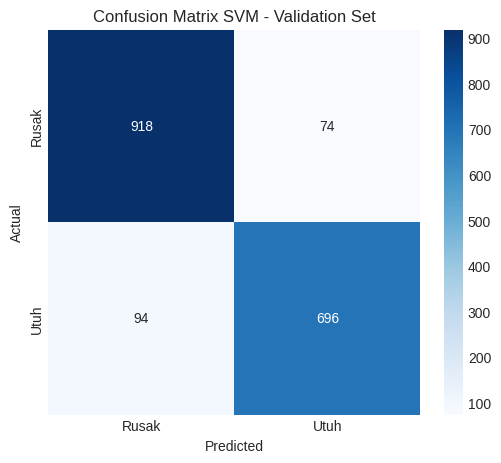

In [ ]:
# ==========================================
# STEP 6 — VALIDASI SVM
# ==========================================
y_val_pred = svm.predict(X_val_s)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_acc*100:.2f}%\n")
print(classification_report(y_val, y_val_pred, target_names=le_qual.classes_))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val, y_val_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le_qual.classes_,
            yticklabels=le_qual.classes_)
plt.title("Confusion Matrix SVM - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

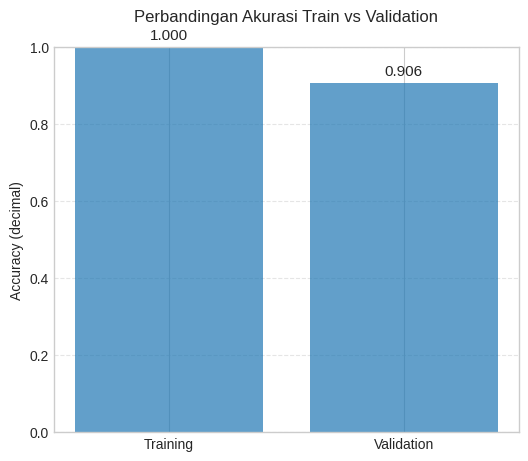


Evaluasi Training vs Validation
Training Accuracy:   1.0000
Validation Accuracy: 0.9057
Gap (Train - Val):   0.0943
✅ Good Fitting: Train dan Validation seimbang.


In [ ]:
# ===================================================
# EVALUASI TRAIN vs VALIDATION
# ===================================================

# Hitung akurasi
acc = {
    "train": accuracy_score(y_train, y_train_pred),
    "val": accuracy_score(y_val, y_val_pred)
}
gap_tv = acc["train"] - acc["val"]

# Visualisasi (Bar Chart)
plt.figure(figsize=(6, 5))
plt.bar(["Training", "Validation"], [acc["train"], acc["val"]], alpha=0.7)

plt.title("Perbandingan Akurasi Train vs Validation\n")
plt.ylabel("Accuracy (decimal)")
plt.ylim(0, 1)

# Label di atas bar
for i, (label, value) in enumerate(acc.items()):
    plt.text(i, value + 0.02, f"{value:.3f}", ha="center", fontsize=11)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

print("\nEvaluasi Training vs Validation")
print(f"Training Accuracy:   {acc['train']:.4f}")
print(f"Validation Accuracy: {acc['val']:.4f}")
print(f"Gap (Train - Val):   {gap_tv:.4f}")

# Analisis kondisi model
if gap_tv > 0.10 and acc["val"] < acc["train"]:
    print("⚠️ Overfitting: Train jauh lebih tinggi daripada Validation.")
elif acc["train"] < 0.70 and acc["val"] < 0.70:
    print("⚠️ Underfitting: Keduanya rendah.")
else:
    print("✅ Good Fitting: Train dan Validation seimbang.")

In [ ]:
# ==========================================
# STEP 6.1 — SAVE MODEL AWAL
# ==========================================

import joblib
import pickle
from datetime import datetime

# Buat direktori untuk menyimpan model jika belum ada
model_dir = Path("saved_models_1")
model_dir.mkdir(exist_ok=True)

# Simpan model SVM
model_filename = model_dir / "svm_initial_model.pkl"
joblib.dump(svm, model_filename)
print(f"Model awal berhasil disimpan di: {model_filename}")

# Simpan juga scaler dan label encoder
scaler_filename = model_dir / "scaler.pkl"
label_encoder_filename = model_dir / "label_encoder.pkl"

joblib.dump(scaler, scaler_filename)
joblib.dump(le_qual, label_encoder_filename)

print(f"Scaler disimpan di: {scaler_filename}")
print(f"Label Encoder disimpan di: {label_encoder_filename}")

# Simpan informasi model
model_info = {
    "training_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "training_accuracy": train_acc,
    "model_parameters": svm.get_params(),
    "n_samples_train": len(X_train_s),
    "n_features": X_train_s.shape[1],
    "classes": le_qual.classes_.tolist(),
}

info_filename = model_dir / "model_info.pkl"
with open(info_filename, 'wb') as f:
    pickle.dump(model_info, f)

print(f"Informasi model disimpan di: {info_filename}")
print("\nModel Info:")
for key, value in model_info.items():
    print(f"  {key}: {value}")

from google.colab import files
files.download("saved_models_1/svm_initial_model.pkl")
files.download("saved_models_1/scaler.pkl")
files.download("saved_models_1/label_encoder.pkl")
files.download("saved_models_1/model_info.pkl")

Model awal berhasil disimpan di: saved_models_1/svm_initial_model.pkl
Scaler disimpan di: saved_models_1/scaler.pkl
Label Encoder disimpan di: saved_models_1/label_encoder.pkl
Informasi model disimpan di: saved_models_1/model_info.pkl

Model Info:
  training_date: 2025-12-13 14:09:49
  training_accuracy: 1.0
  model_parameters: {'C': 10.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
  n_samples_train: 5344
  n_features: 9146
  classes: ['Rusak', 'Utuh']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Testing

Test Accuracy: 91.25%
              precision    recall  f1-score   support

       Rusak       0.91      0.93      0.92       991
        Utuh       0.91      0.89      0.90       791

    accuracy                           0.91      1782
   macro avg       0.91      0.91      0.91      1782
weighted avg       0.91      0.91      0.91      1782

Ringkasan Prediksi (Test Set):
Total Samples   : 1782
Total Benar   : 1626
Total Salah     : 156


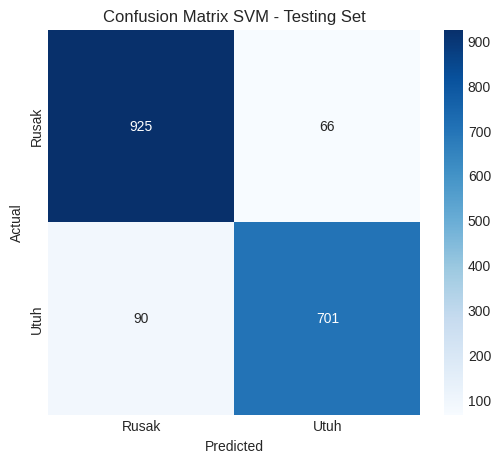

In [ ]:
# ==========================================
# STEP 8 — TESTING SVM (FINAL)
# ==========================================
y_test_pred = svm.predict(X_test_s)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(classification_report(y_test, y_test_pred, target_names=le_qual.classes_))

# Ringkasan total prediksi benar vs salah
total_samples = len(y_test)
total_correct = int(np.sum(y_test_pred == y_test))
total_wrong = int(total_samples - total_correct)
print("Ringkasan Prediksi (Test Set):")
print(f"Total Samples   : {total_samples}")
print(f"Total Benar   : {total_correct}")
print(f"Total Salah     : {total_wrong}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le_qual.classes_,
            yticklabels=le_qual.classes_)
plt.title("Confusion Matrix SVM - Testing Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Ouput


Menampilkan 10 gambar test dengan prediksi...


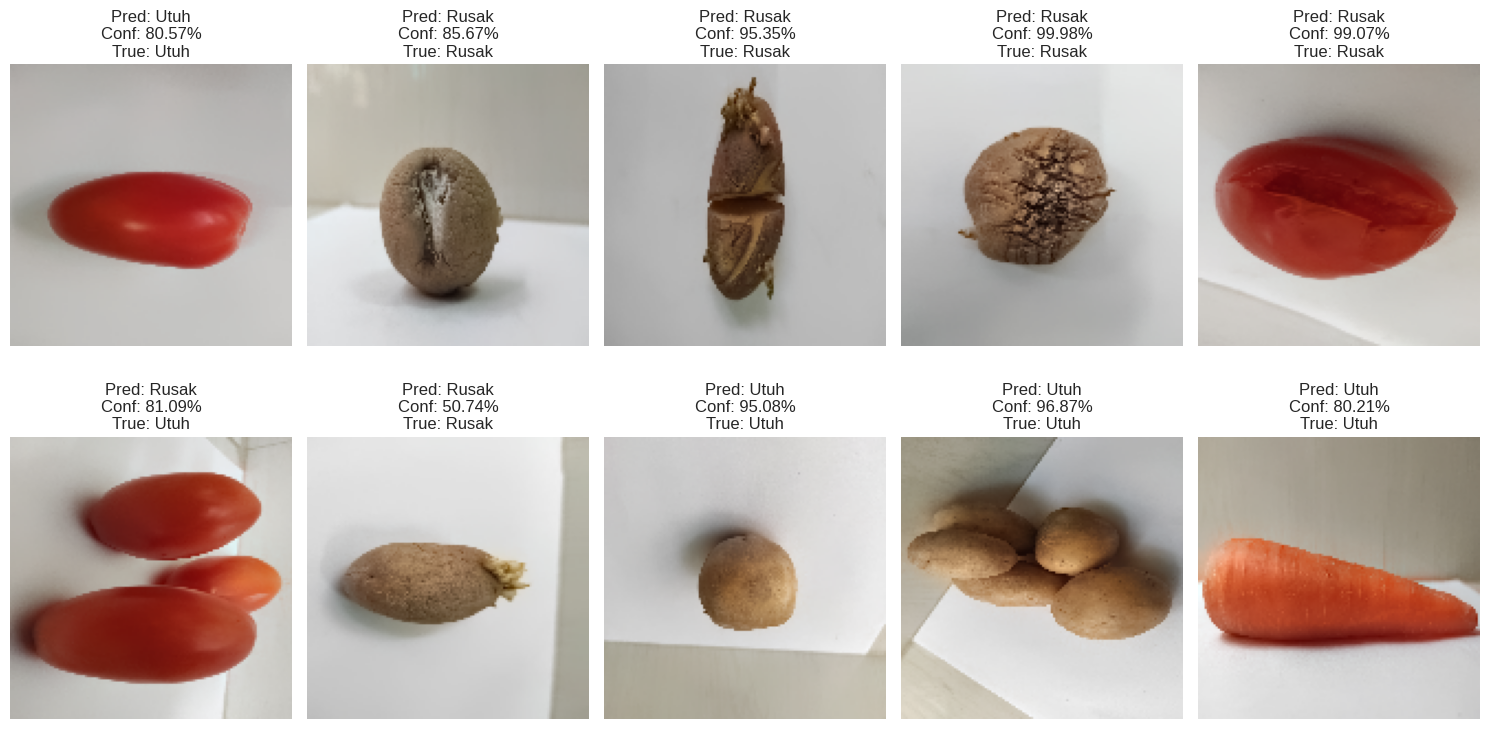

In [ ]:
# ================================================
# OUTPUT KLASIFIKASI + CONFIDENCE (PROBABILITY)
# ================================================

# Ambil probabilitas
proba = svm.predict_proba(X_test_s)

# Prediksi kelas
pred_labels = svm.predict(X_test_s)

# Confidence = probabilitas kelas yang diprediksi
confidence = np.max(proba, axis=1)

# Mapping kembali ke label asli
label_map = {i: cls for i, cls in enumerate(le_qual.classes_)}


print("\nMenampilkan 10 gambar test dengan prediksi...")

indices_to_show = np.random.choice(len(X_test), 10, replace=False)

plt.figure(figsize=(15, 8))

for i, idx_in_test_set in enumerate(indices_to_show):
    plt.subplot(2, 5, i+1)
    # Retrieve the original preprocessed image using idx_test
    original_image_index = idx_test[idx_in_test_set]

    # X_data berisi tuple (index, angle), ambil hanya index untuk mendapatkan gambar
    img_idx, angle = X_data[original_image_index]
    img_show = preprocessed_images[img_idx]

    # Rotate image sesuai angle untuk visualisasi
    img_show = get_augmented_image(img_show, angle)

    plt.imshow(img_show)

    cls = label_map[pred_labels[idx_in_test_set]]
    conf = confidence[idx_in_test_set] * 100
    true = label_map[y_test[idx_in_test_set]]

    plt.title(f"Pred: {cls}\nConf: {conf:.2f}%\nTrue: {true}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Test External Data

In [ ]:
# ==========================================
# STEP 9 — LOAD MODEL & TEST DATA EKSTERNAL
# ==========================================

import joblib
from pathlib import Path

# Path ke folder model yang tersimpan
model_dir = Path("saved_models_1")

# Load model fine-tuned
print("Loading model fine-tuned...")
svm_loaded = joblib.load(model_dir / "svm_initial_model.pkl")
scaler_loaded = joblib.load(model_dir / "scaler.pkl")
le_qual_loaded = joblib.load(model_dir / "label_encoder.pkl")

print("Model berhasil dimuat!")
print(f"Classes: {le_qual_loaded.classes_}")

# Info model
info_tuned_filename = model_dir / "model_info.pkl"
if info_tuned_filename.exists():
    with open(info_tuned_filename, 'rb') as f:
        model_info = pickle.load(f)
    print("\nModel Info:")
    for key, value in model_info.items():
        if key != "improvement_over_initial":
            print(f"  {key}: {value}")


Loading model fine-tuned...
Model berhasil dimuat!
Classes: ['Rusak' 'Utuh']

Model Info:
  training_date: 2025-12-13 14:09:49
  training_accuracy: 1.0
  model_parameters: {'C': 10.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
  n_samples_train: 5344
  n_features: 9146
  classes: ['Rusak', 'Utuh']


In [ ]:
# ==========================================
# STEP 9.1 — LOAD DATA EKSTERNAL
# ==========================================

# Load gambar dari folder eksternal
external_data_path = Path(r"/content/drive/MyDrive/PCVK/test_eksternal_cm2")
external_paths = []

if external_data_path.exists():
    print("Membaca gambar dari folder...")

    # Ambil semua file gambar dari folder
    files = list(external_data_path.glob("*.jpg")) + \
            list(external_data_path.glob("*.png")) + \
            list(external_data_path.glob("*.jpeg")) + \
            list(external_data_path.glob("*.JPG")) + \
            list(external_data_path.glob("*.PNG")) + \
            list(external_data_path.glob("*.JPEG"))

    external_paths = sorted(files)
    print(f"  -> Ditemukan {len(external_paths)} gambar")
else:
    print("⚠️ Path tidak ditemukan! Silakan sesuaikan path ke folder data eksternal Anda.")

print(f"\nTotal gambar eksternal: {len(external_paths)}")

if len(external_paths) > 0:
    # Tampilkan beberapa nama file
    print("\nContoh nama file:")
    for i, path in enumerate(external_paths[:5]):
        print(f"  {i+1}. {path.name}")
    if len(external_paths) > 5:
        print(f"  ... dan {len(external_paths) - 5} file lainnya")


Membaca gambar dari folder...
  -> Ditemukan 15 gambar

Total gambar eksternal: 15

Contoh nama file:
  1. carrot1.jpg
  2. carrot2.jpg
  3. carrot3.jpg
  4. carrot4.jpeg
  5. carrot5.jpg
  ... dan 10 file lainnya


Memproses gambar eksternal...
Total gambar terproses: 15


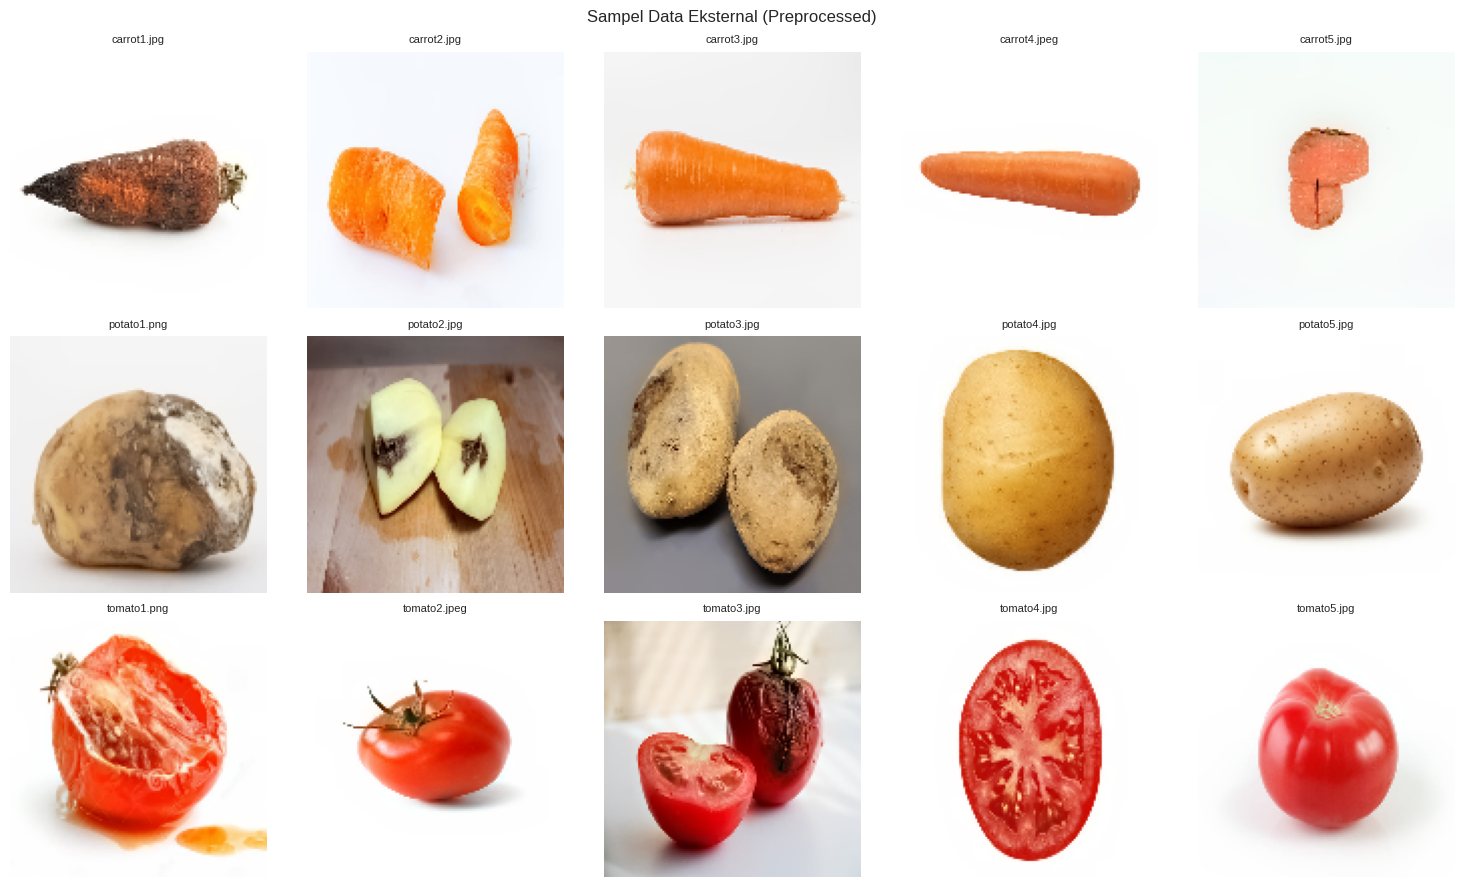

In [ ]:
# ==========================================
# STEP 9.2 — PREPROCESSING DATA EKSTERNAL
# ==========================================

if len(external_paths) > 0:
    print("Memproses gambar eksternal...")

    external_preprocessed = []
    valid_paths = []  # Track paths that were successfully loaded

    for img_path in external_paths:
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"[SKIP] Error loading: {img_path.name}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize
        orig_r = resize_image(img, 128)

        # Guided filter
        den_r = guided_filter_smoothing(orig_r, radius=5, eps=1e-4)

        external_preprocessed.append(den_r)
        valid_paths.append(img_path)

    # Update external_paths to only include successfully loaded images
    external_paths = valid_paths

    print(f"Total gambar terproses: {len(external_preprocessed)}")

    # Visualisasi beberapa sampel
    if len(external_preprocessed) >= 15:
        plt.figure(figsize=(15, 9)) # Adjusted figure height for 3 rows
        for i in range(15): # Changed to display 15 images
            plt.subplot(3, 5, i+1)
            plt.imshow(external_preprocessed[i])
            plt.title(f"{external_paths[i].name}", fontsize=8)
            plt.axis("off")
        plt.suptitle("Sampel Data Eksternal (Preprocessed)")
        plt.tight_layout()
        plt.show()


In [ ]:
# ==========================================
# STEP 9.3 — SEGMENTASI & EKSTRAKSI FITUR DATA EKSTERNAL
# ==========================================

if len(external_preprocessed) > 0:
    print("Melakukan segmentasi dan ekstraksi fitur...")

    external_features = []

    for img in external_preprocessed:
        # Segmentasi
        mask = segmentation(img)

        # Ekstraksi fitur (tanpa augmentasi untuk testing)
        feats = extract_features_with_mask(img, mask)
        external_features.append(feats)

    external_features = np.array(external_features)
    print(f"Feature shape: {external_features.shape}")

    # Scaling menggunakan scaler yang sudah dimuat
    print("Melakukan scaling...")
    external_features_scaled = scaler_loaded.transform(external_features)
    print("Preprocessing selesai!")


Melakukan segmentasi dan ekstraksi fitur...
Feature shape: (15, 9146)
Melakukan scaling...
Preprocessing selesai!


In [ ]:
# ==========================================
# STEP 9.4 — PREDIKSI DATA EKSTERNAL
# ==========================================

if len(external_preprocessed) > 0:
    print("Melakukan prediksi...")

    # Prediksi
    predictions = svm_loaded.predict(external_features_scaled)
    probabilities = svm_loaded.predict_proba(external_features_scaled)

    # Confidence score
    confidence_scores = np.max(probabilities, axis=1)

    # Decode label
    predicted_labels = le_qual_loaded.inverse_transform(predictions)

Melakukan prediksi...


Menampilkan hasil prediksi dengan confidence score...



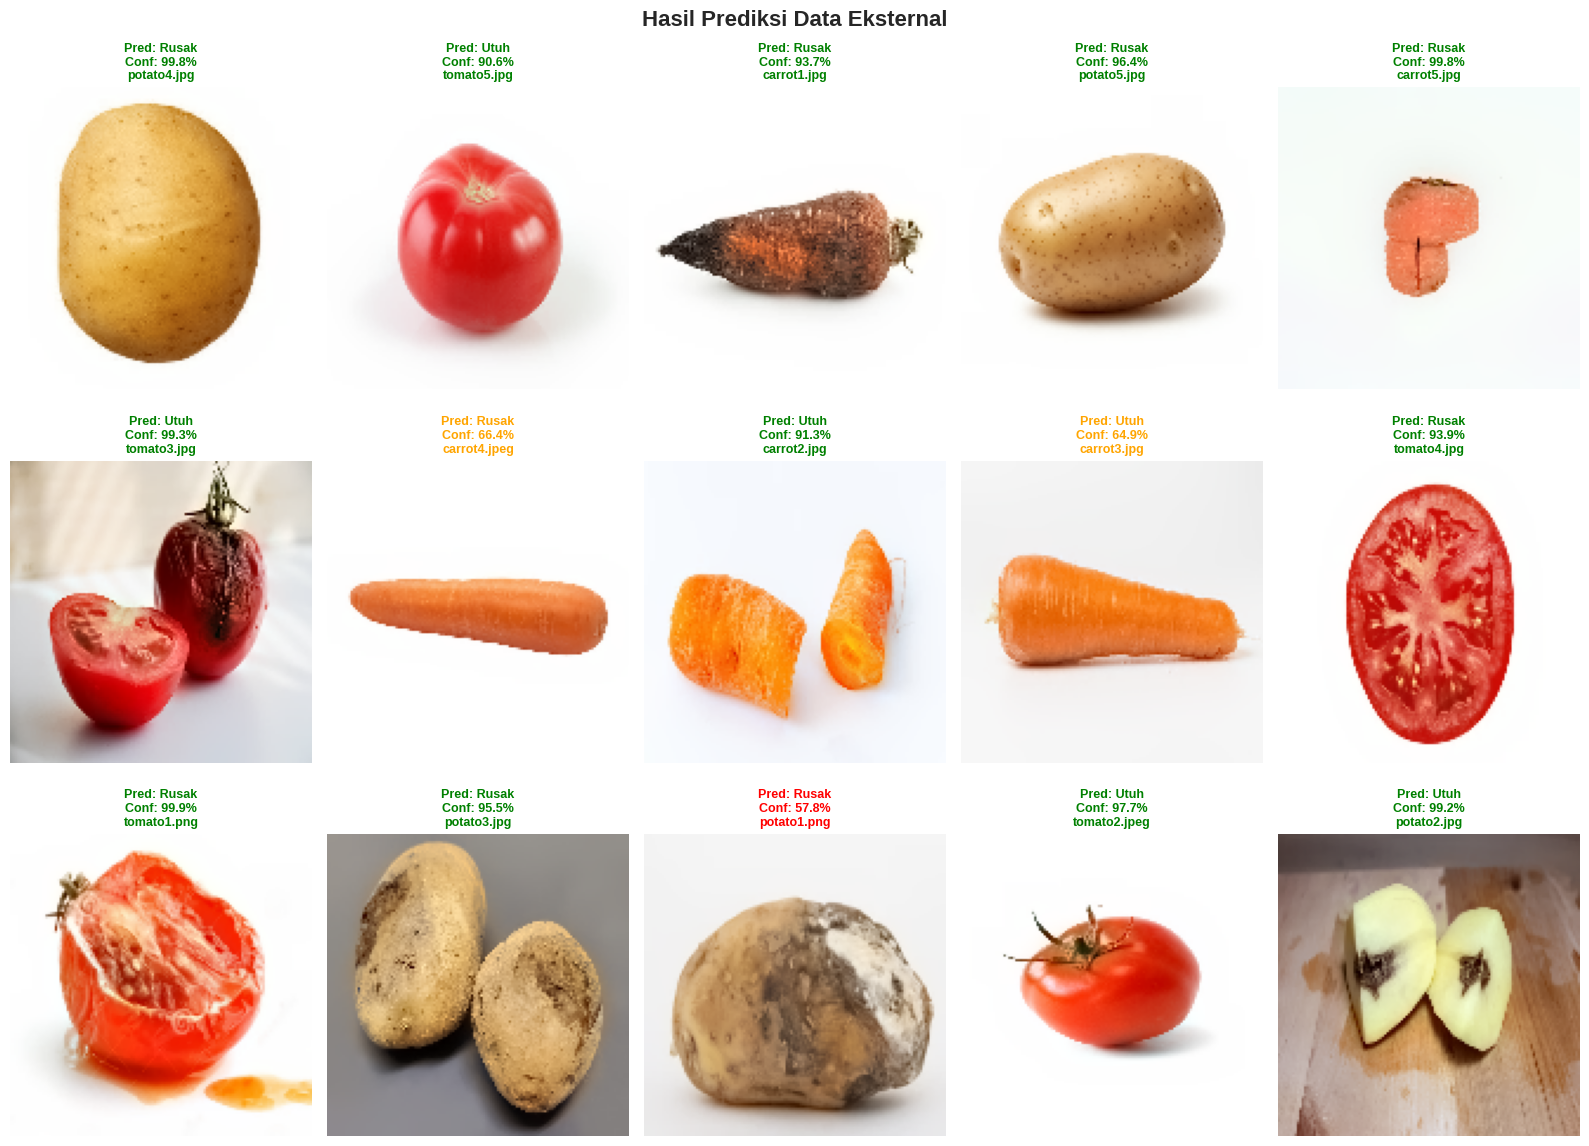


DETAIL PREDIKSI SEMUA GAMBAR
No   File Name                      Predicted Confidence  
--------------------------------------------------------------------------------
1    carrot1.jpg                    Rusak     93.73%
2    carrot2.jpg                    Utuh      91.35%
3    carrot3.jpg                    Utuh      64.92%
4    carrot4.jpeg                   Rusak     66.41%
5    carrot5.jpg                    Rusak     99.79%
6    potato1.png                    Rusak     57.78%
7    potato2.jpg                    Utuh      99.25%
8    potato3.jpg                    Rusak     95.53%
9    potato4.jpg                    Rusak     99.77%
10   potato5.jpg                    Rusak     96.37%
11   tomato1.png                    Rusak     99.91%
12   tomato2.jpeg                   Utuh      97.66%
13   tomato3.jpg                    Utuh      99.26%
14   tomato4.jpg                    Rusak     93.88%
15   tomato5.jpg                    Utuh      90.64%


In [ ]:
# ==========================================
# STEP 9.5 — VISUALISASI HASIL PREDIKSI
# ==========================================

if len(external_preprocessed) > 0:
    print("Menampilkan hasil prediksi dengan confidence score...\n")

    # Pilih sampel untuk visualisasi (max 15 gambar)
    n_samples = min(15, len(external_preprocessed))

    # Random sampling untuk visualisasi
    selected_indices = np.random.choice(len(external_preprocessed), n_samples, replace=False)

    # Plot
    n_cols = 5 # Set to 5 columns as requested
    n_rows = (len(selected_indices) + n_cols - 1) // n_cols # Calculate rows based on n_cols

    plt.figure(figsize=(16, 4 * n_rows))

    for i, idx in enumerate(selected_indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(external_preprocessed[idx])

        pred_label = predicted_labels[idx]
        conf = confidence_scores[idx] * 100
        file_name = external_paths[idx].name

        # Warna berdasarkan confidence
        if conf >= 80:
            color = 'green'
        elif conf >= 60:
            color = 'orange'
        else:
            color = 'red'

        title = f"Pred: {pred_label}\nConf: {conf:.1f}%\n{file_name[:20]}"
        plt.title(title, color=color, fontweight='bold', fontsize=9)
        plt.axis("off")

    plt.suptitle("Hasil Prediksi Data Eksternal", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Tampilkan detail semua prediksi
    print("\n" + "="*80)
    print("DETAIL PREDIKSI SEMUA GAMBAR")
    print("="*80)
    print(f"{'No':<4} {'File Name':<30} {'Predicted':<8} {'Confidence':<12}")
    print("-" * 80)

    for idx in range(len(external_preprocessed)):
        file_name = external_paths[idx].name
        pred = predicted_labels[idx]
        conf = confidence_scores[idx] * 100

        # Truncate filename jika terlalu panjang
        display_name = file_name if len(file_name) <= 28 else file_name[:25] + "..."

        print(f"{idx+1:<4} {display_name:<30} {pred:<8} {conf:>6.2f}%")